Epoch     1 | Loss 4.366e+02 | L2 1.009e+00 | v1 1.998 | v2 9.997
Epoch  1000 | Loss 3.515e+02 | L2 9.712e-01 | v1 1.588 | v2 9.564
Epoch  2000 | Loss 3.370e+02 | L2 9.626e-01 | v1 1.308 | v2 9.431
Epoch  3000 | Loss 3.141e+02 | L2 9.623e-01 | v1 1.119 | v2 9.814
Epoch  4000 | Loss 3.241e+02 | L2 9.619e-01 | v1 0.965 | v2 10.238
Epoch  5000 | Loss 3.157e+02 | L2 9.621e-01 | v1 0.914 | v2 10.628
Epoch  6000 | Loss 3.035e+02 | L2 9.622e-01 | v1 0.949 | v2 10.988
Epoch  7000 | Loss 2.831e+02 | L2 9.620e-01 | v1 0.951 | v2 11.271
Epoch  8000 | Loss 2.863e+02 | L2 9.622e-01 | v1 0.971 | v2 11.501
Epoch  9000 | Loss 2.844e+02 | L2 9.618e-01 | v1 0.975 | v2 11.655
Epoch 10000 | Loss 3.138e+02 | L2 9.620e-01 | v1 0.979 | v2 11.775
Epoch 11000 | Loss 3.061e+02 | L2 9.618e-01 | v1 0.987 | v2 11.818
Epoch 12000 | Loss 3.012e+02 | L2 9.618e-01 | v1 1.004 | v2 11.859
Epoch 13000 | Loss 3.330e+02 | L2 9.619e-01 | v1 0.996 | v2 11.890
Epoch 14000 | Loss 3.550e+02 | L2 9.619e-01 | v1 0.984 | v2 11.889

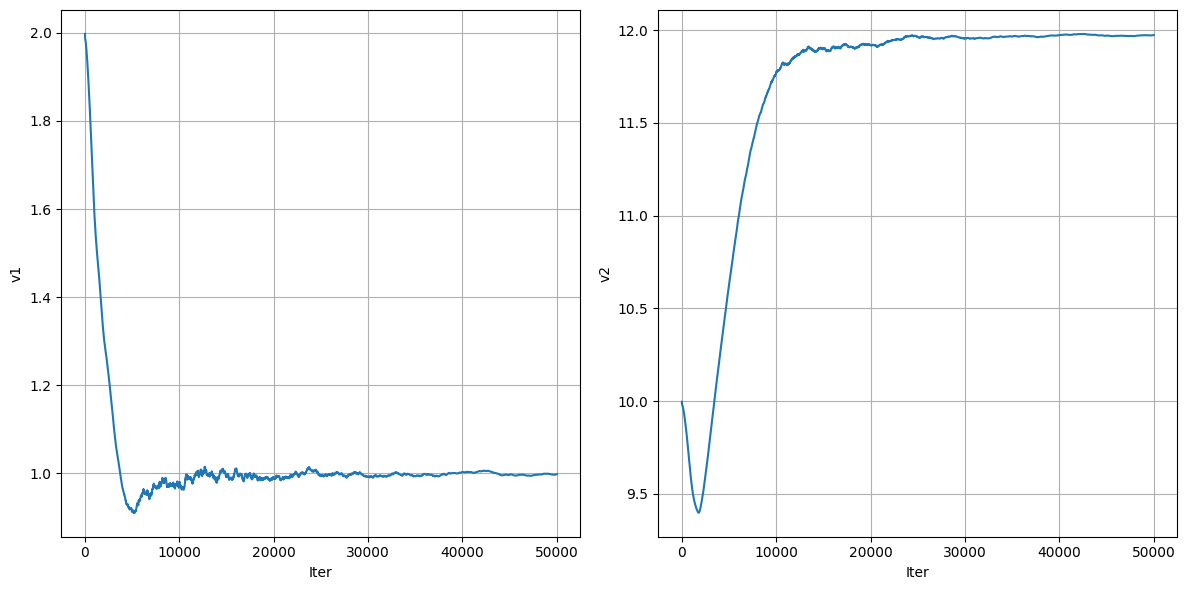

In [ ]:
import torch
import numpy as np
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

# ========= 全局可调参数 ========= #
EPSILON = 5          # 噪声乘数 ε
SIGMA   = 0.5          # 噪声标准差 σ
DATA_LOSS_WEIGHT = 50  # 数据项权重，调大可放大噪声影响
EPOCHS  = 50000        # 训练迭代次数
# ================================= #

sin, cos, exp, pi = torch.sin, torch.cos, torch.exp, torch.pi
torch.set_default_dtype(torch.float64)

# ----- 随机数种子（固定可复现实验；设为 None 则随机） ----- #
def setup_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
setup_seed()

# ----- 噪声函数 ε·N(0,σ²) ----- #
def add_noise(z, epsilon=1.0, sigma=0.1):
    noise = epsilon * np.random.normal(loc=0.0, scale=sigma, size=z.shape)
    return z + noise

# ----- 生成带噪声真解数据 ----- #
x = np.linspace(-3, 3)
y = np.linspace(-3, 3)
t = np.linspace(0, 1, 200)

def gen_testdata(epsilon=0.0, sigma=0.0):
    xx, yy, tt = np.meshgrid(x, y, t, indexing='ij')
    usol = np.sin(2 * xx + tt)              # 真解
    X = np.vstack((xx.ravel(), yy.ravel(), tt.ravel())).T
    z = usol.flatten()[:, None]
    z_noisy = add_noise(z, epsilon, sigma)
    return X, z_noisy

def l2_relative_error(z_true, z_pred):
    return np.linalg.norm(z_true - z_pred) / np.linalg.norm(z_true)

# ----- 采样函数（PDE Interior / BC / IC / Data） ----- #
N, N1, N2 = 2000, 100, 200
def interior(n=N):
    x = torch.rand(n,1)*6-3; y = torch.rand(n,1)*6-3; t = torch.rand(n,1)
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), torch.zeros_like(t)

def ini(n=N1):
    x = torch.rand(n,1)*6-3; y = torch.rand(n,1)*6-3; t = torch.zeros(n,1)
    cond = torch.sin(2*x)
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), cond

def left(n=N1):
    t = torch.rand(n,1); x = -3*torch.ones_like(t); y = torch.rand(n,1)*6-3
    cond = torch.sin(-6 + t)
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), cond

def right(n=N1):
    t = torch.rand(n,1); x = 3*torch.ones_like(t); y = torch.rand(n,1)*6-3
    cond = torch.sin(6 + t)
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), cond

def up(n=N1):
    t = torch.rand(n,1); y = 3*torch.ones_like(t); x = torch.rand(n,1)*6-3
    cond = torch.sin(2*x + t)
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), cond

def down(n=N1):
    t = torch.rand(n,1); y = -3*torch.ones_like(t); x = torch.rand(n,1)*6-3
    cond = torch.sin(2*x + t)
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), cond

def data_interior(n=N2):
    X, Y = gen_testdata(EPSILON, SIGMA)     # 全局噪声参数
    ids = np.random.randint(X.shape[0], size=n)
    xy_t = torch.from_numpy(X[ids]).requires_grad_(True)
    cond = torch.from_numpy(Y[ids])
    return xy_t, cond

# ----- MLP 网络 ----- #
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(3, 64), torch.nn.Tanh(),
            torch.nn.Linear(64, 64), torch.nn.Tanh(),
            torch.nn.Linear(64, 64), torch.nn.Tanh(),
            torch.nn.Linear(64, 1),
        )
    def forward(self, x): return self.net(x)

loss_fn = torch.nn.MSELoss()

def gradients(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                   create_graph=True, only_inputs=True)[0]
    return gradients(gradients(u, x), x, order-1)

# ----- 要反求的参数 ----- #
v1 = torch.nn.Parameter(torch.tensor([2.0], dtype=torch.float64))
v2 = torch.nn.Parameter(torch.tensor([10.0], dtype=torch.float64))

# ----- 各损失项 ----- #
def l_interior(u):
    x,y,t,_ = interior()
    u_val = u(torch.cat([x,y,t],1))
    u_t = gradients(u_val,t,1); u_x = gradients(u_val,x,1); u_y = gradients(u_val,y,1)
    u_xx = gradients(u_val,x,2); u_yy = gradients(u_val,y,2)
    residual = (u_t - 6*u_val*(u_x**2 + u_y**2) - 3*(u_val**2)*(u_xx+u_yy)
                - v1*cos(2*x+t) + 24*sin(2*x+t)*cos(2*x+t)**2 - v2*sin(2*x+t)**3)
    return loss_fn(residual, torch.zeros_like(residual))

def l_bc_ic(u, sampler):
    x,y,t,cond = sampler()
    return loss_fn(u(torch.cat([x,y,t],1)), cond)

def l_data(u):
    xy_t, cond = data_interior()
    return loss_fn(u(xy_t), cond)

# =================== 训练 =================== #
u_net = MLP()
opt = torch.optim.RAdam(list(u_net.parameters()) + [v1, v2], lr=1e-3)
scheduler = StepLR(opt, step_size=1000, gamma=0.9)

# 记录
v1_hist, v2_hist, iter_hist, err_hist = [], [], [], []

# 测试集（同噪声级别）用于 L2 误差评估
xy_t_test, u_real_test = gen_testdata(EPSILON, SIGMA)
xy_t_test = torch.from_numpy(xy_t_test)

for epoch in range(1, EPOCHS+1):
    opt.zero_grad()

    l_i   = l_interior(u_net)
    l_d   = l_data(u_net)
    l_ini = l_bc_ic(u_net, ini)
    l_l   = l_bc_ic(u_net, left)
    l_r   = l_bc_ic(u_net, right)
    l_u   = l_bc_ic(u_net, up)
    l_dn  = l_bc_ic(u_net, down)

    total_loss = l_i + l_ini + l_l + l_r + l_u + l_dn + DATA_LOSS_WEIGHT * l_d
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(u_net.parameters(), 0.5)
    opt.step(); scheduler.step()

    # 记录
    v1_hist.append(v1.item()); v2_hist.append(v2.item()); iter_hist.append(epoch)

    if epoch % 1000 == 0 or epoch == 1:
        with torch.no_grad():
            u_pred = u_net(xy_t_test).numpy()
        err = l2_relative_error(u_real_test, u_pred)
        err_hist.append(err)
        print(f"Epoch {epoch:5d} | Loss {total_loss.item():.3e} | L2 {err:.3e} | v1 {v1.item():.3f} | v2 {v2.item():.3f}")

print(f"\nFinal v1 = {v1.item():.6f}, v2 = {v2.item():.6f}")

# --------- 可视化参数收敛 --------- #
plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.plot(iter_hist, v1_hist); plt.xlabel('Iter'); plt.ylabel('v1'); plt.grid(True)
plt.subplot(1,2,2); plt.plot(iter_hist, v2_hist); plt.xlabel('Iter'); plt.ylabel('v2'); plt.grid(True)
plt.tight_layout(); plt.show()


Epoch     1 | Loss 8.572e+01 | L2 1.085e+00 | v1 1.998 | v2 9.997
Epoch  1000 | Loss 1.114e+01 | L2 4.958e-01 | v1 1.695 | v2 9.780
Epoch  2000 | Loss 9.621e+00 | L2 4.966e-01 | v1 1.367 | v2 10.099
Epoch  3000 | Loss 8.772e+00 | L2 4.926e-01 | v1 1.094 | v2 10.515
Epoch  4000 | Loss 8.577e+00 | L2 4.910e-01 | v1 0.967 | v2 10.927
Epoch  5000 | Loss 8.272e+00 | L2 4.911e-01 | v1 0.946 | v2 11.283
Epoch  6000 | Loss 8.002e+00 | L2 4.913e-01 | v1 0.973 | v2 11.573
Epoch  7000 | Loss 7.310e+00 | L2 4.906e-01 | v1 0.984 | v2 11.775
Epoch  8000 | Loss 7.464e+00 | L2 4.914e-01 | v1 0.998 | v2 11.898
Epoch  9000 | Loss 7.400e+00 | L2 4.905e-01 | v1 0.999 | v2 11.948
Epoch 10000 | Loss 8.062e+00 | L2 4.908e-01 | v1 1.003 | v2 11.972
Epoch 11000 | Loss 7.942e+00 | L2 4.904e-01 | v1 0.999 | v2 11.972
Epoch 12000 | Loss 7.802e+00 | L2 4.904e-01 | v1 1.001 | v2 11.977
Epoch 13000 | Loss 8.469e+00 | L2 4.904e-01 | v1 0.998 | v2 11.981
Epoch 14000 | Loss 9.156e+00 | L2 4.904e-01 | v1 0.998 | v2 11.9

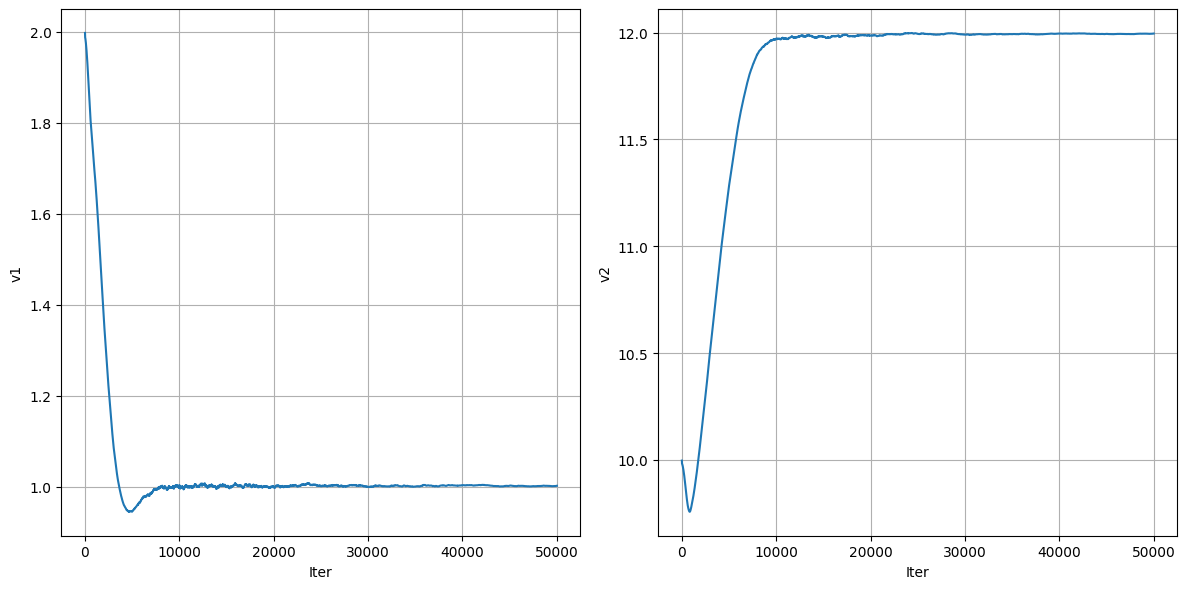

In [ ]:
import torch
import numpy as np
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

# ========= 全局可调参数 ========= #
EPSILON = 2          # 噪声乘数 ε
SIGMA   = 0.2          # 噪声标准差 σ
DATA_LOSS_WEIGHT = 50  # 数据项权重，调大可放大噪声影响
EPOCHS  = 50000        # 训练迭代次数
# ================================= #

sin, cos, exp, pi = torch.sin, torch.cos, torch.exp, torch.pi
torch.set_default_dtype(torch.float64)

# ----- 随机数种子（固定可复现实验；设为 None 则随机） ----- #
def setup_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
setup_seed()

# ----- 噪声函数 ε·N(0,σ²) ----- #
def add_noise(z, epsilon=1.0, sigma=0.1):
    noise = epsilon * np.random.normal(loc=0.0, scale=sigma, size=z.shape)
    return z + noise

# ----- 生成带噪声真解数据 ----- #
x = np.linspace(-3, 3)
y = np.linspace(-3, 3)
t = np.linspace(0, 1, 200)

def gen_testdata(epsilon=0.0, sigma=0.0):
    xx, yy, tt = np.meshgrid(x, y, t, indexing='ij')
    usol = np.sin(2 * xx + tt)              # 真解
    X = np.vstack((xx.ravel(), yy.ravel(), tt.ravel())).T
    z = usol.flatten()[:, None]
    z_noisy = add_noise(z, epsilon, sigma)
    return X, z_noisy

def l2_relative_error(z_true, z_pred):
    return np.linalg.norm(z_true - z_pred) / np.linalg.norm(z_true)

# ----- 采样函数（PDE Interior / BC / IC / Data） ----- #
N, N1, N2 = 2000, 100, 200
def interior(n=N):
    x = torch.rand(n,1)*6-3; y = torch.rand(n,1)*6-3; t = torch.rand(n,1)
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), torch.zeros_like(t)

def ini(n=N1):
    x = torch.rand(n,1)*6-3; y = torch.rand(n,1)*6-3; t = torch.zeros(n,1)
    cond = torch.sin(2*x)
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), cond

def left(n=N1):
    t = torch.rand(n,1); x = -3*torch.ones_like(t); y = torch.rand(n,1)*6-3
    cond = torch.sin(-6 + t)
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), cond

def right(n=N1):
    t = torch.rand(n,1); x = 3*torch.ones_like(t); y = torch.rand(n,1)*6-3
    cond = torch.sin(6 + t)
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), cond

def up(n=N1):
    t = torch.rand(n,1); y = 3*torch.ones_like(t); x = torch.rand(n,1)*6-3
    cond = torch.sin(2*x + t)
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), cond

def down(n=N1):
    t = torch.rand(n,1); y = -3*torch.ones_like(t); x = torch.rand(n,1)*6-3
    cond = torch.sin(2*x + t)
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), cond

def data_interior(n=N2):
    X, Y = gen_testdata(EPSILON, SIGMA)     # 全局噪声参数
    ids = np.random.randint(X.shape[0], size=n)
    xy_t = torch.from_numpy(X[ids]).requires_grad_(True)
    cond = torch.from_numpy(Y[ids])
    return xy_t, cond

# ----- MLP 网络 ----- #
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(3, 64), torch.nn.Tanh(),
            torch.nn.Linear(64, 64), torch.nn.Tanh(),
            torch.nn.Linear(64, 64), torch.nn.Tanh(),
            torch.nn.Linear(64, 1),
        )
    def forward(self, x): return self.net(x)

loss_fn = torch.nn.MSELoss()

def gradients(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                   create_graph=True, only_inputs=True)[0]
    return gradients(gradients(u, x), x, order-1)

# ----- 要反求的参数 ----- #
v1 = torch.nn.Parameter(torch.tensor([2.0], dtype=torch.float64))
v2 = torch.nn.Parameter(torch.tensor([10.0], dtype=torch.float64))

# ----- 各损失项 ----- #
def l_interior(u):
    x,y,t,_ = interior()
    u_val = u(torch.cat([x,y,t],1))
    u_t = gradients(u_val,t,1); u_x = gradients(u_val,x,1); u_y = gradients(u_val,y,1)
    u_xx = gradients(u_val,x,2); u_yy = gradients(u_val,y,2)
    residual = (u_t - 6*u_val*(u_x**2 + u_y**2) - 3*(u_val**2)*(u_xx+u_yy)
                - v1*cos(2*x+t) + 24*sin(2*x+t)*cos(2*x+t)**2 - v2*sin(2*x+t)**3)
    return loss_fn(residual, torch.zeros_like(residual))

def l_bc_ic(u, sampler):
    x,y,t,cond = sampler()
    return loss_fn(u(torch.cat([x,y,t],1)), cond)

def l_data(u):
    xy_t, cond = data_interior()
    return loss_fn(u(xy_t), cond)

# =================== 训练 =================== #
u_net = MLP()
opt = torch.optim.RAdam(list(u_net.parameters()) + [v1, v2], lr=1e-3)
scheduler = StepLR(opt, step_size=1000, gamma=0.9)

# 记录
v1_hist, v2_hist, iter_hist, err_hist = [], [], [], []

# 测试集（同噪声级别）用于 L2 误差评估
xy_t_test, u_real_test = gen_testdata(EPSILON, SIGMA)
xy_t_test = torch.from_numpy(xy_t_test)

for epoch in range(1, EPOCHS+1):
    opt.zero_grad()

    l_i   = l_interior(u_net)
    l_d   = l_data(u_net)
    l_ini = l_bc_ic(u_net, ini)
    l_l   = l_bc_ic(u_net, left)
    l_r   = l_bc_ic(u_net, right)
    l_u   = l_bc_ic(u_net, up)
    l_dn  = l_bc_ic(u_net, down)

    total_loss = l_i + l_ini + l_l + l_r + l_u + l_dn + DATA_LOSS_WEIGHT * l_d
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(u_net.parameters(), 0.5)
    opt.step(); scheduler.step()

    # 记录
    v1_hist.append(v1.item()); v2_hist.append(v2.item()); iter_hist.append(epoch)

    if epoch % 1000 == 0 or epoch == 1:
        with torch.no_grad():
            u_pred = u_net(xy_t_test).numpy()
        err = l2_relative_error(u_real_test, u_pred)
        err_hist.append(err)
        print(f"Epoch {epoch:5d} | Loss {total_loss.item():.3e} | L2 {err:.3e} | v1 {v1.item():.3f} | v2 {v2.item():.3f}")

print(f"\nFinal v1 = {v1.item():.6f}, v2 = {v2.item():.6f}")

# --------- 可视化参数收敛 --------- #
plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.plot(iter_hist, v1_hist); plt.xlabel('Iter'); plt.ylabel('v1'); plt.grid(True)
plt.subplot(1,2,2); plt.plot(iter_hist, v2_hist); plt.xlabel('Iter'); plt.ylabel('v2'); plt.grid(True)
plt.tight_layout(); plt.show()
